# Random forest predictions

In [172]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from scipy import stats
import utils as u
import copy

import matplotlib.pylab as plt
plt.style.use('ggplot')

def root_mean_squared_log_error(y_true, y_pred):
    # Alternatively: sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5
    assert (y_true >= 0).all() 
    assert (y_pred >= 0).all()
    log_error = np.log1p(y_pred) - np.log1p(y_true)  # Note: log1p(x) = log(1 + x)
    return np.mean(log_error ** 2) ** 0.5

%run utils.py

In [173]:
metaData = u.getAllMetadata()

train = u.getAllTrainData()
# train.rename(columns={'id_x' : 'apartment_id'}, inplace=True)
# train.drop('id_y', axis=1, inplace=True)

test = u.getAllTestData()
# test.rename(columns={'id_x' : 'apartment_id'}, inplace=True)
# test.drop('id_y', axis=1, inplace=True)
test = test.fillna(test.mean())

In [222]:
####### SETTINGS ##############
test_size = 0.2
random_state_split = 42
outliers_value = 4
all_features = ['seller','area_total','area_kitchen','area_living','floor','rooms','layout','ceiling','bathrooms_shared','bathrooms_private','windows_court','windows_street','balconies','loggias','condition','phones','building_id', 'new','latitude','longitude','district','constructed','material','stories','elevator_without','elevator_passenger','elevator_service','parking','garbage_chute','heating']
features = ["area_total", "ceiling", "latitude", "longitude", "floor", "condition", "rooms", "district", "stories"] 
n_estimators=100
criterion='mse'          #root_mean_squared_log_error
max_depth=400
min_samples_split=2
min_samples_leaf=2
min_weight_fraction_leaf=0.00008
max_features='auto'
max_leaf_nodes=None
min_impurity_decrease=1100
bootstrap=True
oob_score=False
n_jobs=None
random_state_model=None
verbose=0
warm_start=False
ccp_alpha=20000
max_samples=None



In [223]:
# from sklearn.linear_model import LinearRegression
# import utils

# ############ CLEAN DATA ###############

# ##### NEW POSITION
# train_data_mod = train.copy()
# train_data_mod["latitude"] = train_data_mod["latitude"] -  train_data_mod["latitude"].mean()
# train_data_mod["longitude"] = train_data_mod["longitude"] -  train_data_mod["longitude"].mean()

# # Convert to polar coordinates
# train_data_mod["r"] =  np.sqrt(train_data_mod["latitude"]**2 + train_data_mod["longitude"]**2)
# train_data_mod["theta"] = np.arctan(train_data_mod["longitude"]/train_data_mod["latitude"])
# train = train_data_mod
# train.columns

# train = train[np.abs(stats.zscore(train["price"]) < 7)]
# plt.plot(train['r'], train['price'], ".")


# # for price in range()
# trendline = np.polyfit(train['r'], (train['price']), 10)
# trend = np.poly1d(trendline)
# r_new = np.linspace(train['r'].min(), train['r'].max(), 23005)

# train.sort_values('r', inplace=True)

# price_new = trend(train['r'])

# train['price_new'] = price_new

# # plt.plot(r_new, price_new)
# # plt.xlim([0, 0.8])
# # plt.ylim([0, 0.2e9])
# # plt.show()



In [224]:
import utils
###### MISSING VALUES
# area_living
train = utils.fillnaReg(train, ['area_total'], 'area_living')

# area_kitchen
train = utils.fillnaReg(train, ['area_total', 'area_living'], 'area_kitchen')

# ceiling
train = utils.fillnaReg(train, ['stories'], 'ceiling')

# # district
# train = utils.fillnaReg(train, ['r', 'theta'], 'district')

In [225]:
#### 1-hot
# u.oneHotFeature(metaData, train, 'district')
# values = u.oneHotFeature(metaData, train, 'heating')
# features = features + values
# print(train.columns)

In [226]:
train.fillna(train.mean(), inplace = True)
train_data, test_data = train_test_split(train, test_size=test_size, random_state=random_state_split, stratify=np.log(train.price).round())
# train_data = train_data[np.abs(stats.zscore(train_data["price"]) < 4)]
# train_data = train_data[(np.abs(stats.zscore(train_data[["rooms", "price"]], axis=0, ddof=0)) < outliers_value).all(axis=1)]              #[(np.abs(stats.zscore(train_data['price'])) < outliers_value)]



In [227]:
########### Balancing prices

# lower_quantile = 0.01
# upper_quantile = 0.95
# train_data_mid = train_data[(train_data['price']>=train_data['price'].quantile(lower_quantile)) & (train_data['price']<=train_data['price'].quantile(upper_quantile))]
# train_data_outside = train_data[(train_data['price']<train_data['price'].quantile(lower_quantile)) | (train_data['price']>train_data['price'].quantile(upper_quantile))]

# train_data_mid = train_data_mid.head(int(train_data_mid.shape[0] * 0.15))
# train_data_temp = pd.concat([train_data_mid, train_data_outside])

# fig, (ax1, ax2) = plt.subplots(figsize=(16, 4), ncols=2, dpi=100)
# sns.histplot(np.log10(train_data.price).rename('log10(price)'), ax=ax1)
# ax1.set_title('Before change')
# sns.histplot(np.log10(train_data_temp.price).rename('log10(price)'), ax=ax2)
# ax2.set_title('After removing central data')


In [228]:
X_train, y_train = train_data[features], train_data['price']
X_test, y_test = test_data[features], test_data['price']

In [229]:
# nonCategorical, categorical = u.getNonCategoricalAndCategoricalFeatures(metaData)
# nonCategorical = list(set(nonCategorical).intersection(features))
# categorical = list(set(categorical).intersection(features))

# # Only normalize/scale the numerical data. Categorical data is kept as is.
# X_train_nonCategorical = X_train[nonCategorical]
# X_test_nonCategorical = X_test[nonCategorical]

# std_scale = preprocessing.StandardScaler().fit(X_train_nonCategorical)
# train_labels_scaled = std_scale.transform(X_train_nonCategorical)
# test_labels_scaled = std_scale.transform(X_test_nonCategorical)

# training_norm_col = pd.DataFrame(train_labels_scaled, index=X_train_nonCategorical.index, columns=X_train_nonCategorical.columns) 
# X_train.update(training_norm_col)

# testing_norm_col = pd.DataFrame(test_labels_scaled, index=X_test_nonCategorical.index, columns=X_test_nonCategorical.columns) 
# X_test.update(testing_norm_col)

In [230]:
def runRF(X_train, y_train, X_test, y_test, 
    n_estimators = 100, max_depth=400, min_samples_split=2, min_samples_leaf=2, min_weight_fraction_leaf=0.00008, 
    max_features='auto', max_leaf_nodes=None, min_impurity_decrease=1100, bootstrap=True, oob_score=False, n_jobs=None,
    random_state=None, verbose=0, warm_start=False, ccp_alpha=20000, max_samples=None):
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf= min_samples_leaf,
        min_weight_fraction_leaf=min_weight_fraction_leaf,
        max_features=max_features,
        max_leaf_nodes=max_leaf_nodes,
        min_impurity_decrease=min_impurity_decrease,
        bootstrap=bootstrap,
        oob_score=oob_score,
        n_jobs=n_jobs,
        random_state=random_state,
        verbose=verbose,
        warm_start=warm_start,
        ccp_alpha=ccp_alpha,
        max_samples=max_samples
    )
    model.fit(X_train, y_train)
    rf_prediction = model.predict(X_test)
    rf_msle = root_mean_squared_log_error(rf_prediction, y_test)
    return rf_msle

def optimizeParam(X_train, y_train, X_test, y_test, start, end, step, divider=1):
    x = []
    y = []
    for value in range(start, end, step):
        if divider!=1: value = value/divider
        x.append(value)
        y.append(runRF(X_train, y_train, X_test, y_test, max_samples=value))
    plt.plot(x, y)
    plt.xlabel('max_samples parameter values')
    plt.ylabel('RMLSE')

def optimizeParamCategorical(X_train, y_train, X_test, y_test, values):
    x = []
    y = []
    for value in values:
        x.append(value)
        y.append(runRF(X_train, y_train, X_test, y_test, warm_start=value))
    plt.plot(x, y)
    plt.xlabel('warm_start parameter values')
    plt.ylabel('RMLSE')

# optimizeParamCategorical(X_train, y_train, X_test, y_test, [True, False])

In [231]:
model2 = RandomForestRegressor(
    n_estimators=n_estimators,
    criterion=criterion,
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf,
    min_weight_fraction_leaf=min_weight_fraction_leaf,
    max_features=max_features,
    max_leaf_nodes=max_leaf_nodes,
    min_impurity_decrease=min_impurity_decrease,
    bootstrap=bootstrap,
    oob_score=oob_score,
    n_jobs=n_jobs,
    random_state=random_state_model,
    verbose=verbose,
    warm_start=warm_start,
    ccp_alpha=ccp_alpha,
    max_samples=max_samples
)

In [232]:
model2.fit(X_train, y_train)

RandomForestRegressor(ccp_alpha=20000, max_depth=400,
                      min_impurity_decrease=1100, min_samples_leaf=2,
                      min_weight_fraction_leaf=8e-05)

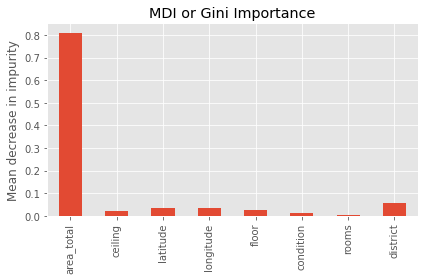

In [233]:
u.getFeatureImportanceGraph(model2, X_train)

In [234]:
# import seaborn as sns

# corr = train_data.corr()
# mask = np.zeros_like(corr)
# mask[np.triu_indices_from(mask)] = True

# f,ax = plt.subplots(figsize=(18, 18))
# sns.heatmap(train_data.corr(), mask=mask, vmax=0.6, square=True, cmap='coolwarm', annot=True, linewidths=.5, fmt= '.1f',ax=ax)
# plt.title('Correlations all data')

In [235]:
rf_prediction = model2.predict(X_test)
rf_mse = root_mean_squared_log_error(rf_prediction, y_test)
print('Test MSE:', rf_mse)

Test MSE: 0.1684429281669531


Text(0, 0.5, 'Ground Truth')

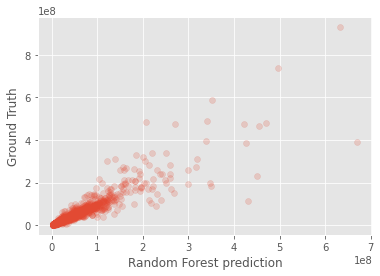

In [236]:
plt.scatter(rf_prediction, y_test, alpha=0.2)
plt.xlabel('Random Forest prediction')
plt.ylabel('Ground Truth')

In [237]:
# ########## Create submission
# import json
# import utils
# # Fit model to the full dataset 

# # # ##### NEW POSITION
# # test_data_mod = test.copy()
# # test_data_mod["latitude"] = test_data_mod["latitude"] -  test_data_mod["latitude"].mean()
# # test_data_mod["longitude"] = test_data_mod["longitude"] -  test_data_mod["longitude"].mean()

# # # Convert to polar coordinates
# # test_data_mod["r"] =  np.sqrt(test_data_mod["latitude"]**2 + test_data_mod["longitude"]**2)
# # test_data_mod["theta"] = np.arctan(test_data_mod["longitude"]/test_data_mod["latitude"])
# # test = test_data_mod
# # test.columns


# ###### MISSING VALUES
# # area_living
# test = utils.fillnaReg(test, ['area_total'], 'area_living')
# # area_kitchen
# test = utils.fillnaReg(test, ['area_total', 'area_living'], 'area_kitchen')
# # ceiling
# test = utils.fillnaReg(test, ['stories'], 'ceiling')
# # # district
# # test = utils.fillnaReg(test, ['r', 'theta'], 'district')

# # test.sort_values('r', inplace=True)

# # price_new = trend(test['r'])

# # test['price_new'] = price_new



# ############## Balacing prices
# # train = train.fillna(train.mean())
# # test = test.fillna(test.mean())
# # train = train[(np.abs(stats.zscore(train['price'])) < outliers_value)]

# # lower_quantile = 0.01
# # upper_quantile = 0.95
# # train_data_mid = train[(train['price']>=train['price'].quantile(lower_quantile)) & (train['price']<=train['price'].quantile(upper_quantile))]
# # train_data_outside = train[(train['price']<train['price'].quantile(lower_quantile)) | (train['price']>train['price'].quantile(upper_quantile))]

# # train_data_mid = train_data_mid.head(int(train_data_mid.shape[0] * 0.15))
# # train_data_temp = pd.concat([train_data_mid, train_data_outside])

# # train = train_data_temp


# X_train = train[features]
# y_train = train['price']
# print(f'Num nans in train {X_train.isna().any(axis=1).sum()}')
# model = RandomForestRegressor(
#     n_estimators=n_estimators,
#     criterion=criterion,
#     max_depth=max_depth,
# #     min_samples_split=2,
# #     min_samples_leaf=2,
#     min_weight_fraction_leaf=min_weight_fraction_leaf,
#     max_features=max_features,
#     max_leaf_nodes=max_leaf_nodes,
#     min_impurity_decrease=min_impurity_decrease,
#     bootstrap=bootstrap,
#     oob_score=oob_score,
#     n_jobs=n_jobs,
#     random_state=random_state_model,
#     verbose=verbose,
#     warm_start=warm_start,
#     ccp_alpha=ccp_alpha,
#     max_samples=max_samples
# )
# model.fit(X_train, y_train)

# # Generate predictions for test set 
# X_test = test[features]
# X_test_nan = X_test.isna().any(axis=1)
# print(f'Num nans in test: {X_test_nan.sum()}')
# y_test_hat = model.predict(X_test[~X_test_nan])

# # Construct submission dataframe
# submission = pd.DataFrame()
# submission['id'] = test.id
# submission.loc[~X_test_nan, 'price_prediction'] = y_test_hat # Predict on non-nan entries
# submission['price_prediction'].fillna(y_train.mean(), inplace=True) # Fill missing entries with mean predictor
# print(f'Generated {len(submission)} predictions')

# # Export submission to csv with headers

# ############################################ CHANGE NAME !!!!!!!!!!
# submission.to_csv('sample_RF_12.csv', index=False)
# settings = {
#     'train_MSE': root_mean_squared_log_error(rf_prediction, y_test),
#     'features':features, 
#     'outliers_value':outliers_value,
#     'nan_delete':'mean',
#     'test_size' : test_size,
#     'random_state_split' :  random_state_split,
#     'n_estimators': n_estimators,
#     'criterion': criterion,
#     'max_depth': max_depth,
#     'min_weight_fraction_leaf': min_weight_fraction_leaf,
#     'max_features': max_features,
#     'max_leaf_nodes': max_leaf_nodes,
#     'min_impurity_decrease': min_impurity_decrease,
#     'bootstrap': bootstrap,
#     'oob_score': oob_score,
#     'n_jobs': n_jobs,
#     'random_state': random_state_model,
#     'verbose': verbose,
#     'warm_start': warm_start,
#     'ccp_alpha': ccp_alpha,
#     'max_samples': max_samples,
#     'other':{0:'Modified the code to have the right parameters',
#         'Missing values' : {
#             "Missing area_living": "reg on area_total", 
#             "Missing area_kitchen": "reg on area_total and area_living", 
#             "Missing ceiling": "reg on stories"
#         }    
#     }
# }

# with open('sample_RF_12_settings.json', 'w') as fp:
#     json.dump(settings, fp)